### Data Cleaning

In [8]:
# Cell #1 - Data Cleaning on Location
# Keeps campaigns that are only from the US (some campaigns are in USD but based outside the US) 
# Splits Location Column (written as City, State) into two seperate columns (City and State)
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("..")
cwd = os.getcwd()
df = pd.read_csv(cwd + '/data/updated_csv_filtered_FINAL.csv') # reads from filtered csv file

df = df[df.Country == 'US'] # keeps campaigns only in the US
df['Location'] = df['Location'].fillna('') # replaces NaN locations with empty strings

df['State'] = df['Location'].str.split(',').str[1]
df['City'] = df['Location'].str.split(',').str[0]

df.to_csv(cwd + '/data/updated_csv_filtered_FINAL.csv', index=False)

### Sentiment Analysis 

In [12]:
# Cell #2 - Adding Sentiment Analysis Features
# Runs VADER sentiment analysis on campaign Titles and Descriptions
# See README.md file for more information about features generated 

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from nltk.corpus import stopwords
stopwrds = stopwords.words('english')
from nltk.tokenize import word_tokenize, sent_tokenize

analyzer = SentimentIntensityAnalyzer()
df = pd.read_csv(cwd + '/data/updated_csv_filtered_FINAL.csv')

df['Description'] = df['Description'].fillna("") # fill NaN descriptions with empty strings to run VADER
df['Title'] = df['Title'].fillna("") # fill NaN titles with empty strings to run VADER

df['Compound_Description'] = [analyzer.polarity_scores(txt)['compound'] for txt in df['Description']]
df['Neg_Description'] = [analyzer.polarity_scores(txt)['neg'] for txt in df['Description']]
df['Neu_Description'] = [analyzer.polarity_scores(txt)['neu'] for txt in df['Description']]
df['Pos_Description'] = [analyzer.polarity_scores(txt)['pos'] for txt in df['Description']]

df['Compound_Title'] = [analyzer.polarity_scores(txt)['compound'] for txt in df['Title']]
df['Neg_Title'] = [analyzer.polarity_scores(txt)['neg'] for txt in df['Title']]
df['Neu_Title'] = [analyzer.polarity_scores(txt)['neu'] for txt in df['Title']]
df['Pos_Title'] = [analyzer.polarity_scores(txt)['pos'] for txt in df['Title']]

df['Description_Length'] = df['Description'].str.split().str.len()
df['Title_Length'] = df['Title'].str.split().str.len()

print("Average Description Length: ", df["Description_Length"].mean())
print("Average Title Length: ", df["Title_Length"].mean())

df.to_csv("GFM_Data_VADER_Sentiment.csv", index=False)

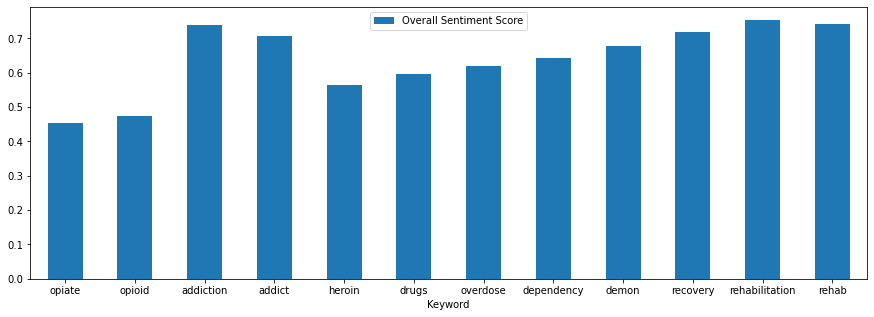

In [16]:
# Cell #3 - Sentiment Analysis Bar Chart
# Creates a chart to show average compound sentiment analysis score per keyword

from matplotlib import pyplot as plt
import pandas as pd

df = pd.read_csv(cwd + '/data/GFM_Data_VADER_Sentiment.csv') 

# create new dataframe for each keyword consisting of rows that correspond to campaigns associated with the keyword
opiate = df[df['All_Keywords'].str.contains("opiate")] 
opioid = df[df['All_Keywords'].str.contains("opioid")]
addiction = df[df['All_Keywords'].str.contains("addiction")]
addict = df[df['All_Keywords'].str.contains("addict")]
heroin = df[df['All_Keywords'].str.contains("heroin")]
drugs = df[df['All_Keywords'].str.contains("drugs")]
overdose = df[df['All_Keywords'].str.contains("overdose")]
dependency = df[df['All_Keywords'].str.contains("dependency")]
demon = df[df['All_Keywords'].str.contains("demon")]
recovery = df[df['All_Keywords'].str.contains("recovery")]
rehabilitation = df[df['All_Keywords'].str.contains("rehabilitation")]
rehab = df[df['All_Keywords'].str.contains("rehab")]

# calculate the average compound sentiment score of the description for each keyword 
opiate_sent = opiate["Compound_Description"].mean()
opioid_sent = opioid["Compound_Description"].mean()
addiction_sent = addiction["Compound_Description"].mean()
addict_sent = addict["Compound_Description"].mean()
heroin_sent = heroin["Compound_Description"].mean()
drugs_sent = drugs["Compound_Description"].mean()
overdose_sent = overdose["Compound_Description"].mean()
dependency_sent = dependency["Compound_Description"].mean()
demon_sent = demon["Compound_Description"].mean()
recovery_sent = recovery["Compound_Description"].mean()
rehabilitation_sent = rehabilitation["Compound_Description"].mean()
rehab_sent = rehab["Compound_Description"].mean()

# create bar chart for overall sentiment score of description per keyword 
df = pd.DataFrame({'Keyword':['opiate', 'opioid', 'addiction', 'addict', 'heroin', 'drugs', 'overdose', 'dependency', 'demon', 'recovery', 'rehabilitation', 'rehab'], 
                   'Overall Sentiment Score':[opiate_sent, opioid_sent, addiction_sent, addict_sent, heroin_sent, drugs_sent, overdose_sent, dependency_sent, demon_sent, recovery_sent, rehabilitation_sent, rehab_sent]})
ax = df.plot.bar(x='Keyword', y='Overall Sentiment Score', rot=0, figsize=(15,5))
# fig = ax.get_figure()
# fig.savefig('sentscore_per_keyword.png')

### Location Based Features (Median Income & Rural/Urban Designation)

The following cells add location-based features to the dataset including rural/urban designation per county and median income by city. This data was generated by merging csv files with external data on the location fields in GFM_Data_VADER_Sentiment.csv. These files have not been added to the GitHub repository but links to the data can be found below. Any preprocessing required on these files to run the succeeding code blocks is also listed below. 

 - **Location (City, State) to Zipcode Crosswalk:** https://www.unitedstateszipcodes.org/zip-code-database/ 
   <br/> File in Code: *free-zipcode-database.csv*
   <br/> Information: Dataset that contains zipcodes associated with cities in the United States 
   <br/> Preprocessing: As cities can often link to multiple zipcodes if there is overlap, duplicate zipcodes need to be removed from this data file before it can be used in the code cells below.
 
 - **Zipcode to County (FIPS Code) Crosswalk:** https://www.huduser.gov/portal/datasets/usps_crosswalk.html 
   <br/> File in Code: *ZIP_COUNTY_122020.csv*
   <br/> Information: Dataset taken from the US Department of Housingand Urban Development that links city zipcodes to FIPS codes (codes associated with counties) and is located on the website as ZIP-COUNTY.
   <br/> Preprocessing:  As zipcodes can sometimes link to multiple counties if there is overlap, duplicate zipcodes need to be removed from this data file before it can be used in the code cells below.
   
 - **County (FIPS Code) to Rural Urban Designation Crosswalk:** https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx 
   <br/> File in Code: *ruralurbancodes2013.csv*
   <br/> Information: Dataset taken from the US Department of Agriculture that designates a RUCC code (1 - 9) describing how rural or urban a county is. The file used is "2013 Rural-Urban Continuum Codes" from the website.
   <br/> Preprocessing: The file provided uses numbers as designation of how rural or urban a county is. To make this easier to understand, this code was converted to the following descriptions which were added to the file under the column "Description" which was used to the designate the locations campaigns were based in as metropolitan, suburban, or rural.
    - 1: Metro Large
    - 2: Metro Medium
    - 3: Metro Small
    - 4: Suburban Large
    - 5: Suburban Medium
    - 6: Suburban Small
    - 7: Rural Large
    - 8: Rural Medium
    - 9: Rural Small
   
 
 - **Zipcode to Census Median Income Crosswalk:** https://data.census.gov/cedsci/table?q=median%20income&g=0100000US.860000&tid=ACSST5Y2019.S1901&hidePreview=true 
   <br/> File in Code: *ACS_5Y_2019_Median_Income.csv*
   <br/> Information: Dataset that contains median income, number of families, and mean income per zipcode in the United States based on 5 year ACS data from 2019. 
   <br/> Preprocessing: Extraneous columns were removed and column names were renamed

In [19]:
# Cell #4 - Adding Rural Urban Designation Features 
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('GFM_sentiment_length.csv') 
df_free_zipcode = pd.read_csv('free-zipcode-database.csv')

# Import zipcode data and renaming columns
df_free_zipcode = df_free_zipcode.rename(columns={'Location': 'Loc', 'LocationText': 'Location'})

# GFM Data dataframe with dataframe containing zipcode information
df3 = pd.merge(df, df_free_zipcode, on = 'Location', how='inner')

# Importing county data and renaming columns
df4 = pd.read_csv('ZIP_COUNTY_122020.csv')
df4 = df4.rename(columns={'ZIP': 'Zipcode'})

# Merging dataframe with GFM Data and zipcodes with county data
df5 = pd.merge(df3, df4, on = 'Zipcode', how='inner')

# Importing rural-urban data and renaming columns
df6 = pd.read_csv('ruralurbancodes2013.csv')
df6 = df6.rename(columns={'FIPS': 'COUNTY'})

# Merging dataframe with GFM Data, zipcodes, and county data with rural-urban designation data
df7 = pd.merge(df5, df6, on = 'COUNTY', how='inner')

# Renaming ambiguous column names
df7 = df7.rename(columns={'COUNTY': 'Fips', 'Description_y': 'Rural_Urban', 'Country_x': 'Country', 'City_x': 'City', 'State_x': 'State_GFM', 'City_y': 'RU_City', 'Description_x': 'Description'})

# Deleting extraneous columns
del df7['State_y']
del df7['LocationType']
del df7['Xaxis']
del df7['Yaxis']
del df7['Zaxis']
del df7['WorldRegion']
del df7['Country_y']
del df7['Loc']
del df7['Decommisioned']
del df7['TaxReturnsFiled']
del df7['EstimatedPopulation']
del df7['TotalWages']
del df7['Notes']
del df7['RES_RATIO']
del df7['BUS_RATIO']
del df7['OTH_RATIO']
del df7['TOT_RATIO']
del df7['State']
del df7['RUCC_2013']
del df7['ZipCodeType']
del df7['RecordNumber']
del df7['RU_City']

# Renaming ambiguous columns
df7 = df7.rename(columns={'State_GFM': 'State'})

print(df7.dtypes)
df7.to_csv("GFM_rural_urban.csv", index=False)


URL                      object
All_Keywords             object
Title                    object
Reason_For_Fund          object
Total_Raised            float64
Total_Goal              float64
Percent_Reached         float64
Campaign_Date            object
Organizer                object
Beneficiary              object
Location                 object
Donors                  float64
Shares                  float64
Followers               float64
Num_Updates             float64
Num_Comments            float64
Is_Charity                 bool
Charity                  object
Currency_Code            object
Donation_Count          float64
Comments_Enabled           bool
Donations_Enabled          bool
Country                  object
Is_Business                bool
Is_Team                    bool
Campaign_Photo_URL       object
Description              object
State                    object
City                     object
Compound_Description    float64
Neg_Description         float64
Neu_Desc

In [16]:
# Cell #5 - Median Income Designation Features 
import pandas as pd
from matplotlib import pyplot as plt

# Import zipcode data and GFM data and renaming columns
df = pd.read_csv('GFM_sentiment_length.csv') 
df_free_zipcode = pd.read_csv('free-zipcode-database.csv')
df_free_zipcode = df_free_zipcode.rename(columns={'Location': 'Loc', 'LocationText': 'Location'})

# Merging dataframe with GFM Data and zipcodes with county data
df3 = pd.merge(df, df_free_zipcode, on = 'Location', how='inner')

# Importing census income data and renaming columns
df4 = pd.read_csv('ACS_5Y_2019_Median_Income.csv')
df4 = df4.rename(columns={'Geographic Area Name': 'Zipcode'})

# Merging dataframe with GFM Data and zipcodes with census income data
df5 = pd.merge(df3, df4, on = 'Zipcode', how='inner')

# Deleting extraneous columns
del df5['Decommisioned']
del df5['TaxReturnsFiled']
del df5['EstimatedPopulation']
del df5['TotalWages']
del df5['Notes']
del df5['ZipCodeType']
del df5['RecordNumber']
del df5['City_y']
del df5['State_y']
del df5['LocationType']
del df5['Xaxis']
del df5['Yaxis']
del df5['Zaxis']
del df5['WorldRegion']
del df5['Country_y']
del df5['Loc']


df5 = df5.rename(columns={'id': 'Census ID', 'State_x': 'City_x'})
print(df5.dtypes)

df5.to_csv("GFM_incomedata.csv", index=False)

URL                      object
All_Keywords             object
Title                    object
Reason_For_Fund          object
Total_Raised            float64
Total_Goal              float64
Percent_Reached         float64
Campaign_Date            object
Organizer                object
Beneficiary              object
Location                 object
Donors                  float64
Shares                  float64
Followers               float64
Num_Updates             float64
Num_Comments            float64
Is_Charity                 bool
Charity                  object
Currency_Code            object
Donation_Count          float64
Comments_Enabled           bool
Donations_Enabled          bool
Country_x                object
Is_Business                bool
Is_Team                    bool
Campaign_Photo_URL       object
Description              object
City_x                   object
City_x                   object
Compound_Description    float64
Neg_Description         float64
Neu_Desc